# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from google.colab import files
from PIL import Image
from io import BytesIO

# Chapter Introduction

- uses of RNNs: 
 - analyze time series data (stock prices)
 - anticipate car trajectories/help avoid car accidents
 - work on sequences of arbitrary lengths (natural language processing)
---
- RNNs face 2 main difficulties: 
 - unstable gradients
 - very limited short-term memory
---
- RNNs are not the only types of neural networks that can handle sequential data: 
 - for small sequences, a regular dense network can do the trick
 - for very long sequences (audio samples or text), convolutional neural networks can actually do the trick
---
- a *WaveNet* is a CNN architecture that can handle sequences of tens of thousands of time steps

# Recurrent Neurons and Layers

- so far, we've only focused on feedforward neural networks:
 - the activations flow in one direction from the input to output layer
- **a recurrent neural network is similar to a feedforward neural network, however, it also has connections pointing backward**
---
- a layer of recurrent neurons:
 - **at each time step, every neuron receives both the input vector and the output vector from the previous time step**
- each recurrent neuron has two sets of weights:
 - one for the inputs and the other for the outputs of the previous time step
- representing a RNN against the time axis is called *unrolling the network through time*
---
- many researchers prefer to use the hyperbolic tangent (tanh) activation function in RNNs rather than the ReLU activation function

## Memory Cells

- since the output of a recurrent neuron at a time step is a function of all the inputs from previous time steps, you could say it has a form of *memory*
- a part of a neural network that preserves some state across time steps is called a *memory cell* (or just *cell*)
- a single recurrent neuron, or a layer of recurrent neurons, is a very basic cell:
 - capable of only learning short patterns (~10 steps long)
 - there are more complex and powerful types of cells, which are capable of learning longer patterns
---
- in general, a cell's state at a time step is a function of some inputs at that time step and its state at the previous step:
 - its output at a time step is also a function of the previous state and the current inputs


## Input and Output Sequences

Saving 1-15.PNG to 1-15.PNG


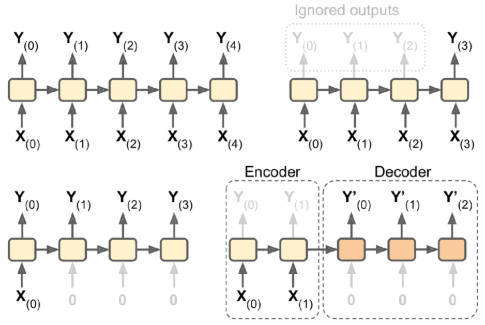

In [2]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['1-15.PNG']))
im

- an RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (top left): 
 - this is a ***sequence-to-sequence network***
 - for example, you could feed it the stock prices over the last number of days and it could output the prices shifted by one day into the future
---
- alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one (top right):
 - this is a ***sequence-to-vector network***
 - for example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (from -1 [hate] to + 1 [love])
---
- conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (bottom left):
 - this is a ***vector-to-sequence network***
 - for example, the input could be an image (or the output of a CNN) and the output could be a caption for that image
---
- lastly, you could have a sequence-to-vector network (an ***encoder***) followed by a vector-to-sequence network (a ***decoder***) (bottom right):
 - for example, this could be used for translating a sentnence from one language to another
 - this two-step model, called an ***Encoder-Decoder***, works much better than trying to translate on the fly with a single sequence-to-sequence RNN

# Training RNNs

- to train an RNN, the trick is to enroll it through time and then simply use regular backpropagation:
 - this strategy is called *backpropagation through time* (BPTT)
---
- similar to regular backpropagation, there is an initial forward pass through the unrolled network:
 - then the output sequence is evaluated using a cost function (this cost function may ignore some outputs) 
 - the gradients of that cost function are then propagated backward through the unrolled network
 - finally, the model parameters are updated using the gradients computed during BPTT
- fortunately, `tf.keras` handles this complexity, so let's start coding:

## Forecasting a Time Series

- suppose you are studying the number of active users per hour on your website, or the daily temperature of your city, or your company's financial health, measured quarterly using multiple metrics:
 - in all these cases, the data will be a sequence of one or more values per time step, which is called a *time series*
 - in the first two examples, there is a single value per time step, so these are *univariate time series*, while in the financial example, there are multiple values per time step (company revenue, debt, etc.), so it is a *multivariate time series*
- a typical task is to predict future values, which is called *forecasting*
- another common task is to fill in the blanks: to predict (or rather "postdict") missing values from the past, which is called *imputation*
---
- for example, the figure below shows 3 univariate time series, each comprised of 50 steps, where the goal is to forecast the value at the next time step (represented by the X)

Saving 2-15.PNG to 2-15.PNG


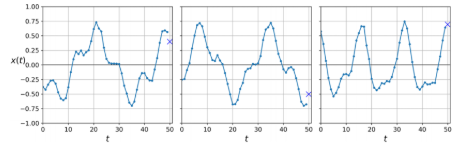

In [3]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['2-15.PNG']))
im

- for simplicity, we are using a time series generated by `generate_time_series()`:

In [0]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

- this function creates as many time series as requested (via the `batch_size` argument), each of length `n_steps`: 
 - there is just one value per time step in each series (all series are univariate)
 - the function returns a NumPy array of shape **[batch size, time steps, 1]**, where each series is the sum of two sine waves of fixed amplitudes with random frequencies and phases, plus a bit of noise
---
- when dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape **[batch size, time steps, dimensionality]**, where *dimensionality* is 1 for univariate time series and more for multivariate time series
---
- now let's create a training set, a validation set, and a test set using this function:

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # 7000 instances
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # 2000 instances
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] # 1000 instances

In [10]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

- `X_train` contains 7,000 time series:
 - shape is `(7000, 50, 1)`
- `X_valid` contains 2,000 time series:
 - shape is `(2000, 50, 1)`
- `X_test` contains 1,000 time series:
 - shape is `(1000, 50, 1)`
---
- since we want to forecast a single value for each series, the targets are column vectors: 
 - for example, `y_train` has a shape of `(7000, 1)`

## Baseline Metrics

- before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models:
 - for example, the simplest approach is to predict the last value in each series, which is called *naive forecasting*
- in this case, it gives us a mean squared error of about 0.020:

In [9]:
# naive predictions
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

- another simple approach is to use a fully connected network: 
 - since it expects a flat list of features for each input, we need to add a `Flatten` layer
- let's just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [12]:
# linear predictions
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086685240269

- if we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.004:
 - this works much better than the naive approach

## Implementing a Simple RNN

- let's see if we can beat our previous results with a simple RNN:

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 10s 48ms/step - loss: 0.011

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0109


0.010881561785936356

- this RNN contains a single layer with a single neuron
- **we do not need to specify the length of the input sequences since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to `None`**
- by default, the `SimpleRNN` layer uses the hyperbolic tangent activation function
---
- by default, recurrent layers in Keras only return the final output
 - to make them return one output per time step, you must set `return_sequences=True`
---
- for each neuron, a linear model has one parameter per input and per time step, plus a bias term:
 - in our linear regression example, that's a total of 51 parameters
- in contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (plus a bias term):
 - in our simple RNN example, that's a total of just 3 parameters


## Trend and Seasonality

- there are many other models to forecast time series, such as *weighted moving average* models or *autoregressive integrated moving average* (ARIMA) models
- some of these models require you to first move the trend:
 - for example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would remove this trend from the time series
 - once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions
- similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe a strong seasonality:
 - you would have to remove this seasonality from the time series
 - again, after the model is trained and makes predictions, you would have to add the seasonal pattern back in to get the final predictions
---
- **when using RNNs, it is generally unnecessary to do this, but it may improve performance in some cases as the model will not have to learn the trend or the seasonality during training**

## Deep RNNs

- it is common to stack multiple layers of cells, which gives you a *deep RNN*
- implementing a deep RNN with `tf.keras` is simple: just stack recurrent layers
- in the following example, we use three `SimpleRNN` layers:
 - note that we could add any other type of recurrent layer, such as an `LSTM` layer or a `GRU` layer

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

# return_sequences=True --> so this model will return one value per time step
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 30s 139ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 30s 137ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 30s 136ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 29s 134ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 30s 138ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 29s 135ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 30s 135ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 14ms/step - loss: 0.0029


0.002910558832809329

- **make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output)**:
 - if you don't, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format
---
- this model reaches an MSE of 0.003, which means we finally managed to beat the linear model
---
- the last layer is not ideal: 
 - it must have a single unit because we want to forecast a univariate time series, which means we must have a single output value per time step
 - moreover, since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range -1 to 1
- **for both these reasons, it might be preferable to replace the output layer with a `Dense` layer (as to avoid complications)**:
 - it would run slightly faster
 - the accuracy would be roughly the same
 - it would allow us to choose any output activation function we want
- if you make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer:
 - this is because this `Dense` output layer cannot handle a 3D array containing a sequence of all the outputs of the previous time steps



In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # make the second SimpleRNN layer return only the last output
    keras.layers.Dense(1) 
])

In [0]:
# exhausting to run
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

## Forecasting Several Time Steps Ahead

- so far, we have only predicted the value at the next time step, but we could just as easily have predicted the value several time steps ahead by changing the targets appropriately:
 - for example, just change the targets to be the value 10 steps ahead instead of 1 
---
- predicting the next 10 values, however, would be different: 
 - the first option is to use the model we have already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occured), then use the model again to predict the following value, and so on

In [0]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [8]:
Y_pred.shape

(1, 10, 1)

- the second option is to train an RNN to predict all 10 next values at once
- we can still use a sequence-to-vector model, but it will output 10 values instead of 1
- however, we first need to change the targets to be vectors containing the next 10 values:

In [0]:
# to predict the next single value
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # 7000 instances
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # 2000 instances
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] # 1000 instances

In [0]:
# to predict the next 10 values
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

- now we just need the output layer to have 10 units instead of 1:

In [0]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(10) # as we are trying to predict the next 10 values
])

- after training this model, you can predict the next 10 values at once very easily:

In [0]:
# exhausting to run
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

- this model works well, however, instead of training the model to forecast the next values only at the very last time step, we can train it to forecast the next 10 values at each and every time step
- **in other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN**: 
 - the advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step
 - this means there will be many more error gradients flowing through the model and they won't have to flow only through time as they will also flow from the output of each time step, which will both stabilize and speed up training
---
- **to be clear, at time step 0, the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1, the model will forecast time steps 2 to 11, and so on, until it finally forecasts time steps 50 to 59 at the last time step**: 
 - each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [18]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

- to turn the model into a sequence-to-sequence model, we must set `return_sequences=True` in all current layers (even the last one), and we must apply the output `Dense` layer at every step
- **Keras offers a `TimeDistributed` layer for this very purpose: it wraps any layer (e.g., a `Dense` layer) and applies it at every step of its input sequence**:
 - it does so by reshaping the inputs from **[batch size, time steps, input dimensions]** to **[batch size x time steps, input dimensions]**
 - in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units, then it runs the `Dense` layer, and finally it reshapes the outputs back to sequences 

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

- **all outputs are needed during training, but only the output at the last time step is useful for predictions and evaluation**
- so although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, which only computes the MSE over the output at the last time step:

In [0]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [0]:
# exhausting to run
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

- when forecasting a time series, it is useful to have some error bars along with your predictions:
 - for this, an efficient technique is MC Dropout
 - add an MC Dropout layer within each memory cell, dropping part of the inputs and hidden states
- after training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step
---
- simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences

## Handling Long Sequences

- to train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network
- just like any deep neural network, it may suffer from the unstable gradients prroblem as it may take forever to train or training may be unstable
- moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence

# Fighting the Unstable Gradients Problem 

- fortunately, many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on
---
- Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets:
 - in fact, you cannot use it between time steps, only between recurrent layers
- to be more precise, it is technically possible to add a BN layer to a memory cell so that it will be applied at each time step, however, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state:
 - in practice, this does not yield good results: researchers have found that the BN was slightly beneficial only when it was applied to the inputs, not to the hidden states
 - in other words, it was slightly better than nothing when applied between recurrent layers, but not within recurrent layers
---
- **another form of normalization that works better with RNNs is *Layer Normalization***:
 - it is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension
- one advantage of Layer Normalization is that it can compute the required statistics on the fly, at each time step, independently for each instance:
 - this means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages
- like BN, Layer Normalization learns a scale and an offset parameter for each input:
 - in an RNN, it is typically used right after the linear combination of the inputs and the hidden states
---
- let's use `tf.keras` to implement Layer Normalization within a simple memory cell:
 - it's just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the hidden `states` from the previous time step
- the `states` argument is a list containing one or more tensors:
 - in the case of a simple RNN cell, it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors
- the following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply Layer Normalization at each step:

In [0]:
from tensorflow.keras.layers import LayerNormalization

In [0]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

- the `call()` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice 
- next, the `call()` method applies Layer Normalization, followed by the activation function
- finally, it returns the output twice (once as the outputs, and once as the new hidden states)
- to use this custom cell, all we need to do is create a `keras.layers.RNN` layer, passing it a cell instance:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [0]:
# exhausting to run
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# Tackling the Short-Term Memory Problem

- due to the transformations that the data goes through when traversing an RNN, some information is lost at each step
- after a while, the RNN's state contains virtually no trace of the first inputs, which can be a showstopper:
 - "Imagine Dory the fish trying to translate a long sentence; by the time she's finished reading it, she has no clue how it started."
- to tackle this problem, various types of cells with long-term memory have been introduced, which have proven so successful that the basic cells are not used much anymore
- let's first look at the most popular of these long-term memory cells: the LSTM cell:

## LSTM cells

- the *Long Short-Term Memory* (LSTM) cell
- **if you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data**
- in Keras, you can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [0]:
# exhausting to run
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

- with LSTM cells, the key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it
- the long-term state goes through a *forget gate*, dropping some memories, but then adds some new memories via the addition operation (which adds the memories that were selected by an *input gate*):
 - so at each time step, some memories are dropped and some memories are added
- moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the *output gate*: 
 - this produces the short-term state (which is equal to the cell's output for this time step)
---
- **in short, an LSTM cell can learn to recognize an important input (role of the input gate), store it in the long-term state, preserve it for as long as it is needed (role of the forget gate), and extract it whenever needed**: 
 - this explains why LSTM cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more

## Peephole connections

- in a regular LSTM cell, the gate controllers can look only at the input and the previous short-term state, however, it may be a good idea to give them a bit more context by letting them peek at the long-term state as well
- moreover, researchers proposed an LSTM variant with extra connections called *peephole* connections: the previous long-term state is added as an input to the controllers of the forget gate and the input gate, and the current long-term state is added as the input to the controller of the output gate: 
 - this often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them
---
- in Keras, the `LSTM` layer is based on the `keras.layers.LSTMCell`, which does not support peepholes
- the experimental `tf.keras.experimental.PeepholeLSTMCell`, however, does, so you can create a `keras.layers.RNN` layer and pass a `PeepholeLSTMCell` to its constructor

## GRU cells

- the *Gated Recurrent Unit* (GRU) cell is a simplified version of the LSTM cell, which seems to perform just as well (which explains its growing popularity) 
- these are the main simplifications:
 - both state vectors are merged into a single vector
 - a single gate controller controls both the forget gate and the input gate
 - there is no output gate as the full state vector is output at every time step, however, there is a new gate controller that controls which part of the previous state will be shown to the main layer
---
- Keras provides a `keras.layers.GRU` layer (based on the `keras.layers.GRUCell` memory cell: 
 - using it is just a matter of replacing `SimpleRNN` or `LSTM` with `GRU`
---
- LSTM and GRU cells are one of the main reasons behind the success of RNNs
- however, while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences:
 - one way to solve this is to shorten the input sequences, for example, using 1D convolutional layers

## Using 1D convolutional layers to process sequences

- in Chapter 14, we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel)
- similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel: 
 - each kernel will learn to detect a single, very short sequential pattern 
- if you use 10 kernels, then the layer's output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently, you can view this output as a single 10-dimensional sequence
- this means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers)
---
- if you use a 1D convolutional layer with a stride of 1 and `"SAME"` padding, then the output sequence will have the same length as the input sequence
- if you use `"VALID"` padding or a stride greater than 1, however, the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly
---
- for example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2 using a stride of 2
- the kernel size is larger than the stride, so all inputs will be used to compute the layer's output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details
- **by shortening the sequences, the convolutional layer may help the `GRU` layers detect longer patterns**
- **note that we must also crop off the first three time steps in the targets (since the kernel's size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2**

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
# [:, 3::2] --> cropping off first 3 time steps in the targets and downsampling the targets by a factor of 2
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

- if you train and evaluate this model, you will find that it is the best model so far
- the convolutional layer really helps, in fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely

## WaveNet

- researchers stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron's inputs are) at every layer: 
 - the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on
- this way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns
- **thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently**

Saving 3-15.PNG to 3-15.PNG


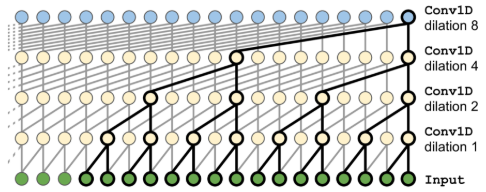

In [41]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['3-15.PNG']))
im

- here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0255 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0249 - last_time_step_mse: 0.0125 - val_loss: 0.0246 - val_last_time_step_mse: 0.0124
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0241 - last_time_step_mse: 0.0118 - val_loss: 0.0235 - val_last_time_step_mse: 0.0110
Epoch 7/20
219/219 [========

- this `Sequential` model starts with an explicit input layer (this is simpler than trying to set `input_shape` only on the first layer), then continues with a 1D convolutional layer using `"casual"` padding:
 - `"casual"` padding ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using `"VALID"` padding
- we then add similar pairs of layers using growing dilations rates: 1, 2, 4, 8, and again, 1, 2, 4, 8
- finally, we add the output layer: a convolutional layer with 10 filters of size 1, and without any activation function
- **every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them**
---
- the last two models offer the best performance so far in forecasting our time series
- in the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks, including text-to-speech tasks, producing incredibly realistic voices across several languages: 
 - they also used the model to generate music, one audio sample at a time
- this feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps, even LSTMs and GRUs cannot handle such long sequences

# Exercises

*1) Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?*

*2) How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?*

*3) If you want to build a deep sequence-to-sequence RNN, which RNN layers should have `return_sequences=True`? What about a sequence-to-vector RNN?*

*4) Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?*

*5) What are the main difficulties when training RNNs? How can you handle them?*

*6) Can you sketch the LSTM cell's architecture?*

*7) Why would you want to use 1D convolutional layers in an RNN?*

*8) Which neural network architecture could you use to classify videos?*

---

1) Here are a few RNN applications:
- For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder-Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
- For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of *collaborative filtering* for a recommender system)
- For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)

2) An RNN layer must have three-dimensional inputs: the first input is the batch size (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be **[5, 10, 2]**. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of **[5, 10, 32]**.

3) To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default). 

4) If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use it a stack of RNN layers (all with `reuturn_sequences=True` except for the top RNN layer). You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step *t*, the target should be a vector containing the values at steps *t* + 1 to *t* + 7).

5) The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning, use a satuarting activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem). 

6) An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. 

7) An RNN layer is fundamentally sequential: in order to compute the outputs at time step *t*, it has to first compute the outputs of all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patteerns. In fact, it is possible to use only convolutional layers, for example by building the WaveNet architecture. 

8) To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-sequence RNN, and finally run its output through a softrmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

### 9) 
*Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.*

- the dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress
- luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 14s 0us/step


In [0]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [0]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [0]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [6]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [0]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [0]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [0]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [0]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [0]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [0]:
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [14]:
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1013s 9ms/step - loss: 4.1344 - accuracy: 0.1620 - sparse_top_k_categorical_accuracy: 0.3621 - val_loss: 3.1576 - val_accuracy: 0.2923 - val_sparse_top_k_categorical_accuracy: 0.5752
Epoch 2/2
107813/107813 [==============================] - 999s 9ms/step - loss: 2.7254 - accuracy: 0.3758 - sparse_top_k_categorical_accuracy: 0.6649 - val_loss: 2.4404 - val_accuracy: 0.4305 - val_sparse_top_k_categorical_accuracy: 0.7184


In [0]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [0]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

### 10. Bach Chorales
*Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach).*

In [2]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

122880/117661 [===============================] - 0s 0us/step


In [0]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [0]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [7]:
train_chorales[0] # single chorale (192) time steps long

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

- notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [0]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

- let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [0]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

- in order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords:
 - ff we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together 
 - it's much better and simpler to predict one note at a time, so we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously)
 - so each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes
 - we will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future
---
- we will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5)
- we will train the model on windows of 128 notes (i.e., 32 chords)
---
- since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data 

In [0]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

- now let's create the training set, the validation set and the test set:

In [0]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

- now let's create the model:
 - we could feed the note values directly to the model, as floats, but this would probably not give good results
 - indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave) 
 - conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other
 - for this reason, we will use an `Embedding` layer to convert each note to a small vector representation
 - we will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`
 - we will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates
 - we will intersperse these layers with `BatchNormalization` layers for faster better convergence
 - then one `LSTM` layer to try to capture long-term patterns
 - and finally a `Dense` layer to produce the final note probabilities, which will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence)
 - so the output shape will be `[batch_size, window_size, 47]`

In [12]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

In [13]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 3s 31ms/step - loss: 1.8143 - accuracy: 0.5366 - val_loss: 4.3564 - val_accuracy: 0.0420
Epoch 2/20
98/98 [==============================] - 2s 19ms/step - loss: 0.8929 - accuracy: 0.7637 - val_loss: 4.3155 - val_accuracy: 0.0916
Epoch 3/20
98/98 [==============================] - 2s 19ms/step - loss: 0.7493 - accuracy: 0.7929 - val_loss: 3.7310 - val_accuracy: 0.1422
Epoch 4/20
98/98 [==============================] - 2s 19ms/step - loss: 0.6752 - accuracy: 0.8081 - val_loss: 2.9692 - val_accuracy: 0.2008
Epoch 5/20
98/98 [==============================] - 2s 19ms/step - loss: 0.6248 - accuracy: 0.8191 - val_loss: 2.7648 - val_accuracy: 0.3244
Epoch 6/20
98/98 [==============================] - 2s 19ms/step - loss: 0.5844 - accuracy: 0.8272 - val_loss: 1.4190 - val_accuracy: 0.5588
Epoch 7/20
98/98 [==============================] - 2s 19ms/step - loss: 0.5475 - accuracy: 0.8368 - val_loss: 0.7156 - val_accuracy: 0.7958
Epoch 8/20
98

- I have not done much hyperparameter searching, so feel free to iterate on this model now and try to optimize it:
 - for example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers
 - you could also play with the number of layers, the learning rate, the optimizer, and so on
---
- once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [14]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

34/34 [==============================] - 0s 13ms/step - loss: 0.7041 - accuracy: 0.8064


[0.7040850520133972, 0.8064130544662476]